<h1 align="center">BENCHMARK - NOTEBOOK<br>Tester Langage naturel -> Requête Solr</h1>

In [13]:
%pip install langchain langchain-mistralai python-dotenv pandas tqdm langchain-ollama matplotlib seaborn -q

Note: you may need to restart the kernel to use updated packages.


### CONFIGURATION UTILISATEUR
**Certaines cellules contiennent les paramètres du script (Tag: `parameters`).**
* Vous **devez** éditer cette section pour définir votre configuration.
* **Commentez** (`#`) ou **décommentez** les lignes pour choisir le modèle, le prompt ou les options d'exécution.

In [14]:
model_name = "ministral-3:3b"
model_name = "qwen2.5-coder:7b"

In [15]:
import os
import pandas as pd
from dotenv import load_dotenv
from langchain_ollama import ChatOllama
import json
import datetime
from tqdm import tqdm
from langchain_core.prompts import ChatPromptTemplate
import requests
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re

loaded = load_dotenv() 
llm = ChatOllama(
    model=model_name,
    temperature=0.2
    )
print(f"Modèle configuré : {llm.model}")


Modèle configuré : qwen2.5-coder:7b


In [16]:
try:
    response = llm.invoke("Bonjour")
    print("Test de connexion réussi ! Réponse du modèle :")
    print(response.content)
except Exception as e:
    print(f"Erreur de connexion : {e}")

Test de connexion réussi ! Réponse du modèle :
Bonjour! Comment puis-je vous aider aujourd'hui?


## Choix de la Stratégie de Prompting

Dans la cellule ci-dessous se trouve un dictionnaire de prompt.
Ils vont être testés sur un dataset de question utilisateur pour voir les résultats du LLM.

* On peut ajouter autant de prompt qu'on veut à ce dictionnaire.

Les requêtes vont être executées sur un solr fictif ainsi que la requête témoin/réponse inscrite sur le dataset.
En comparant les 2 sorties, on pourra dire si oui ou non le LLM a été capable de traduire la demande de l'utilisateur en requête Solr.


In [17]:
# --- Dictionnaire des Prompts à tester ---
PROMPTS_DICT = {
    "1_BASELINE_BAD": """Tu es un expert en administration de moteurs de recherche Solr.
Ta tâche est de traduire des demandes en langage naturel en requêtes Solr syntaxiquement parfaites.
Ne fournis AUCUNE explication, pas de markdown, pas de phrase d'introduction.
Renvoie **uniquement** la chaîne de requête brute.""",

    "2_SCHEMA_ONLY": """Tu es un expert en administration de moteurs de recherche Solr.
Ta tâche est de traduire des demandes en langage naturel en requêtes Solr syntaxiquement parfaites.

### 1. SCHÉMA DE DONNÉES DISPONIBLE
Tu ne dois utiliser QUE les champs suivants. N'invente aucun autre champ.
- doc_type (string) : Type de document (ex: facture, devis, incident, contrat, rapport, commande).
- fournisseur (string) : Nom de l'entité tierce (ex: Haribo, Lutti, Interne).
- montant (float) : Valeur numérique.
- date_creation (date) : Date du document.
- date_modif (date) : Date de modification.
- statut (string) : État du document (ex: Validé, Clôturé, Impayée, Critique).
- assigne_a (string) : Personne responsable (ex: Martin).
- projet (string) : Nom du projet.
- ligne (string) : Identifiant de ligne de production.
- priorite (string) : Niveau d'urgence.
- texte_complet (text) : Pour la recherche floue de mots-clés.

### 2. INSTRUCTION FINALE
Ne fournis AUCUNE explication, pas de markdown, pas de phrase d'introduction.
Renvoie **uniquement** la chaîne de requête brute.""",

    "3_SCHEMA_SYNTAX": """Tu es un expert en administration de moteurs de recherche Solr.
Ta tâche est de traduire des demandes en langage naturel en requêtes Solr syntaxiquement parfaites.

### 1. SCHÉMA DE DONNÉES DISPONIBLE
Tu ne dois utiliser QUE les champs suivants. N'invente aucun autre champ.
- doc_type (string) : Type de document (ex: facture, devis, incident, contrat, rapport, commande).
- fournisseur (string) : Nom de l'entité tierce (ex: Haribo, Lutti, Interne).
- montant (float) : Valeur numérique.
- date_creation (date) : Date du document.
- date_modif (date) : Date de modification.
- statut (string) : État du document (ex: Validé, Clôturé, Impayée, Critique).
- assigne_a (string) : Personne responsable (ex: Martin).
- projet (string) : Nom du projet.
- ligne (string) : Identifiant de ligne de production.
- priorite (string) : Niveau d'urgence.
- texte_complet (text) : Pour la recherche floue de mots-clés.

### 2. RÈGLES DE SYNTAXE CRITIQUES
- **Booléens** : Utilise TOUJOURS les opérateurs en majuscules : AND, OR.
- **Plages** : Utilise les crochets `[MIN TO MAX]`. Pour l'infini, utilise `*` (ex: `[500 TO *]`).
- **Dates** : Utilise les mathématiques de date Solr.
    - "Mois dernier" -> `[NOW-1MONTH/MONTH TO NOW/MONTH]`
    - "Il y a moins de 7 jours" -> `[NOW-7DAYS TO NOW]`
    - "Avant le 1er Jan 2024" -> `[* TO 2024-01-01T00:00:00Z]`
- **Tri** : Si une demande implique un ordre, ajoute `&sort=champ direction` à la fin (ex: `&sort=date_creation desc`).
- **Négation** : Pour "sauf" ou "pas", utilise le signe `-` (ex: `-statut:Clôturé`).
- **Exactitude** : Ne mets pas d'espaces autour des deux points (ex: `champ:valeur`, PAS `champ : valeur`).
- **Pas de crochets pour le texte** : N'utilise JAMAIS les crochets [] pour une recherche de mot simple ou exact. Utilise champ:valeur (sans crochets) ou champ:"phrase exacte" (avec guillemets). Exemple : texte_complet:maintenance (PAS texte_complet:[maintenance]).

### 3. INSTRUCTION FINALE
Ne fournis AUCUNE explication, pas de markdown, pas de phrase d'introduction.
Renvoie **uniquement** la chaîne de requête brute.""",

    "4_SCHEMA_SYNTAX_FEWSHOT": """Tu es un expert en administration de moteurs de recherche Solr.
Ta tâche est de traduire des demandes en langage naturel en requêtes Solr syntaxiquement parfaites.

### 1. SCHÉMA DE DONNÉES DISPONIBLE
Tu ne dois utiliser QUE les champs suivants. N'invente aucun autre champ.
- doc_type (string) : Type de document (ex: facture, devis, incident, contrat, rapport, commande).
- fournisseur (string) : Nom de l'entité tierce (ex: Haribo, Lutti, Interne).
- montant (float) : Valeur numérique.
- date_creation (date) : Date du document.
- date_modif (date) : Date de modification.
- statut (string) : État du document (ex: Validé, Clôturé, Impayée, Critique).
- assigne_a (string) : Personne responsable (ex: Martin).
- projet (string) : Nom du projet.
- ligne (string) : Identifiant de ligne de production.
- priorite (string) : Niveau d'urgence.
- texte_complet (text) : Pour la recherche floue de mots-clés.

### 2. RÈGLES DE SYNTAXE CRITIQUES
- **Booléens** : Utilise TOUJOURS les opérateurs en majuscules : AND, OR.
- **Plages** : Utilise les crochets `[MIN TO MAX]`. Pour l'infini, utilise `*` (ex: `[500 TO *]`).
- **Dates** : Utilise les mathématiques de date Solr.
    - "Mois dernier" -> `[NOW-1MONTH/MONTH TO NOW/MONTH]`
    - "Il y a moins de 7 jours" -> `[NOW-7DAYS TO NOW]`
    - "Avant le 1er Jan 2024" -> `[* TO 2024-01-01T00:00:00Z]`
- **Tri** : Si une demande implique un ordre, ajoute `&sort=champ direction` à la fin (ex: `&sort=date_creation desc`).
- **Négation** : Pour "sauf" ou "pas", utilise le signe `-` (ex: `-statut:Clôturé`).
- **Exactitude** : Ne mets pas d'espaces autour des deux points (ex: `champ:valeur`, PAS `champ : valeur`).
- **Pas de crochets pour le texte** : N'utilise JAMAIS les crochets [] pour une recherche de mot simple ou exact. Utilise champ:valeur (sans crochets) ou champ:"phrase exacte" (avec guillemets). Exemple : texte_complet:maintenance (PAS texte_complet:[maintenance]).

### 3. EXEMPLES (FEW-SHOT)
Input: Factures de plus de 1000€
Output: doc_type:facture AND montant:[1000 TO *]

Input: Documents récents sur la maintenance
Output: texte_complet:maintenance AND date_creation:[NOW-30DAYS TO NOW]

Input: Incidents urgents non assignés
Output: doc_type:incident AND texte_complet:urgent AND -assigne_a:[* TO *]

Input: Les 10 plus grosses commandes
Output: doc_type:commande&sort=montant desc&rows=10

Input: Trie les rapports du plus ancien au plus récent
Output: doc_type:rapport&sort=date_creation asc

### 4. INSTRUCTION FINALE
Ne fournis AUCUNE explication, pas de markdown, pas de phrase d'introduction.
Renvoie **uniquement** la chaîne de requête brute."""
}

print(f"Dictionnaire de Prompts chargé : {len(PROMPTS_DICT)} versions prêtes.")

Dictionnaire de Prompts chargé : 4 versions prêtes.


## Génération Massive des Réponses

C'est ici que nous interrogeons le modèle (`llm`) pour chaque entrée du dataset.
Le script va :
* Parcourir chaque clé du dictionnaire `PROMPTS_DICT`.
* Générer `NUM_ITERATIONS` variantes de réponse pour chaque question.
* Sauvegarder automatiquement les résultats bruts dans des fichiers JSON distincts pour analyse ultérieure.

In [18]:
NUM_ITERATIONS = 1  # Nombre de passages sur le dataset par prompt
dataset_name = "benchmark_dataset.json"

In [19]:
clean_model_name = model_name.replace(":", "-")
clean_dataset_name = os.path.splitext(os.path.basename(dataset_name))[0]

generated_files = []

with open(dataset_name, "r", encoding="utf-8") as f:
    dataset = json.load(f)

# --- BOUCLE PRINCIPALE SUR LES PROMPTS ---
for prompt_key, system_prompt_text in PROMPTS_DICT.items():
    print(f"\nTest du Prompt : {prompt_key}")
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_prompt_text),
        ("user", "{question}")
    ])
    chain = prompt_template | llm

    benchmark_results = []
    
    with tqdm(total=NUM_ITERATIONS * len(dataset), desc=f"Run {prompt_key}") as pbar:
        for i in range(1, NUM_ITERATIONS + 1):
            for entry in dataset:
                question = entry["question"]
                expected = entry["expected_solr"]
                try:
                    response = chain.invoke({"question": question})
                    raw_content = response.content

                    generated = raw_content.strip()
                    
                    # Nettoyage des blocs de code ```solr ... ```
                    generated = generated.replace("```solr", "").replace("```", "").strip("`").strip()
                    
                except Exception as e:
                    generated = f"ERROR: {str(e)}"
                
                is_exact_match = (generated == expected)
                
                benchmark_results.append({
                    "iteration": i,
                    "model": model_name,
                    "dataset": dataset_name,
                    "system_prompt": prompt_key,
                    "difficulty": entry["difficulty"],
                    "question": question,
                    "expected": expected,
                    "generated": generated,
                    "is_exact_match": is_exact_match,
                    "execution_match": None 
                })
                
                pbar.update(1)
                
    date_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    output_dir = os.path.join("results", clean_model_name, clean_dataset_name)
    os.makedirs(output_dir, exist_ok=True)

    filename = f"results_{prompt_key}_{date_str}.json"
    full_path = os.path.join(output_dir, filename)
    with open(full_path, "w", encoding="utf-8") as f:
        json.dump(benchmark_results, f, indent=4, ensure_ascii=False)

    generated_files.append(full_path)

    df_res = pd.DataFrame(benchmark_results)
    acc = df_res["is_exact_match"].mean() * 100
    print(f"Sauvegardé : {full_path}")
    print(f"Précision Textuelle : {acc:.2f}%")

print("Liste des fichiers générés :")
for f in generated_files:
    print(f" - {f}")


Test du Prompt : 1_BASELINE_BAD


Run 1_BASELINE_BAD: 100%|██████████| 25/25 [01:34<00:00,  3.80s/it]


Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_1_BASELINE_BAD_2026-02-11_11-22-36.json
Précision Textuelle : 0.00%

Test du Prompt : 2_SCHEMA_ONLY


Run 2_SCHEMA_ONLY: 100%|██████████| 25/25 [02:06<00:00,  5.05s/it]


Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_2_SCHEMA_ONLY_2026-02-11_11-24-42.json
Précision Textuelle : 20.00%

Test du Prompt : 3_SCHEMA_SYNTAX


Run 3_SCHEMA_SYNTAX: 100%|██████████| 25/25 [01:57<00:00,  4.70s/it]


Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_3_SCHEMA_SYNTAX_2026-02-11_11-26-39.json
Précision Textuelle : 44.00%

Test du Prompt : 4_SCHEMA_SYNTAX_FEWSHOT


Run 4_SCHEMA_SYNTAX_FEWSHOT: 100%|██████████| 25/25 [01:54<00:00,  4.57s/it]

Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_4_SCHEMA_SYNTAX_FEWSHOT_2026-02-11_11-28-34.json
Précision Textuelle : 64.00%
Liste des fichiers générés :
 - results/qwen2.5-coder-7b/benchmark_dataset/results_1_BASELINE_BAD_2026-02-11_11-22-36.json
 - results/qwen2.5-coder-7b/benchmark_dataset/results_2_SCHEMA_ONLY_2026-02-11_11-24-42.json
 - results/qwen2.5-coder-7b/benchmark_dataset/results_3_SCHEMA_SYNTAX_2026-02-11_11-26-39.json
 - results/qwen2.5-coder-7b/benchmark_dataset/results_4_SCHEMA_SYNTAX_FEWSHOT_2026-02-11_11-28-34.json


## Test d'Exécution (Querying Solr)

Nous allons maintenant soumettre les requêtes générées à notre moteur de recherche local pour vérifier deux choses :
1.  **Syntaxe :** La requête fait-elle planter Solr ? (Erreur 400)
2.  **Logique :** La requête renvoie-t-elle exactement les mêmes documents que la requête de référence ?

Cela nous donnera le **Taux de Succès Réel** (`execution_match`), souvent bien supérieur au taux de correspondance textuelle.

In [20]:
SOLR_URL = "http://localhost:8983/solr/benchmark_core/select"

In [21]:
def parse_and_query_solr(query_str):
    """
    Découpe la chaîne (ex: 'q=...&sort=...') pour l'envoyer proprement à l'API Solr.
    Retourne la liste des IDs trouvés ou None si erreur.
    """
    if not query_str or query_str.startswith("ERROR"):
        return None
    params = {
        'fl': 'id',
        'rows': 1000,
        'wt': 'json'
    }
    try:
        # Gestion des paramètres URL (sort, rows, start...)
        if '&' in query_str:
            parts = query_str.split('&')
            params['q'] = parts[0] # La première partie est la query
            for part in parts[1:]:
                if '=' in part:
                    key, value = part.split('=', 1)
                    params[key] = value
        else:
            params['q'] = query_str
        response = requests.get(SOLR_URL, params=params, timeout=2)
        if response.status_code == 200:
            data = response.json()
            # On retourne la liste des IDs
            return [doc['id'] for doc in data.get('response', {}).get('docs', [])]
        else:
            return None # Erreur 400
    except Exception as e:
        return None # Erreur connexion

def compare_results(ids_expected, ids_generated, check_order=False):
    """ Compare deux listes d'IDs (ordre strict ou ensemble). """
    if ids_expected is None or ids_generated is None:
        return False
    
    if check_order:
        return ids_expected == ids_generated
    else:
        return set(ids_expected) == set(ids_generated)

if not generated_files:
    raise FileNotFoundError("Aucun fichier à valider trouvé.")

exec_files = []

for filename in generated_files:
    print(f"\nTraitement : {filename}")

    with open(filename, 'r', encoding='utf-8') as f:
        results_data = json.load(f)
    stats = {"total": len(results_data), "syntax_error": 0, "fixed_by_exec": 0}

    for entry in tqdm(results_data, desc="Validation Solr"):
        # Exécution Vérité Terrain (Expected)
        ids_expected = parse_and_query_solr(entry['expected'])
        # Exécution Modèle (Generated)
        ids_generated = parse_and_query_solr(entry['generated'])
        
        # Si la difficulté contient "sort", on vérifie l'ordre
        is_sort = "sort" in entry.get('difficulty', '')
        is_exec_match = compare_results(ids_expected, ids_generated, check_order=is_sort)
        
        entry['execution_match'] = is_exec_match
        entry['solr_error'] = (ids_generated is None)
        
        if entry['solr_error']:
            stats['syntax_error'] += 1
        
        if is_exec_match and not entry.get('is_exact_match', False):
            stats['fixed_by_exec'] += 1

    dir_name = os.path.dirname(filename)
    base_name = os.path.basename(filename)
    if "results_" in base_name:
        new_base_name = base_name.replace("results_", "results_exec_")
    else:
        new_base_name = f"exec_{base_name}"
    
    new_full_path = os.path.join(dir_name, new_base_name)
    
    with open(new_full_path, 'w', encoding='utf-8') as f:
        json.dump(results_data, f, indent=4, ensure_ascii=False)
    
    exec_files.append(new_full_path)

    df = pd.DataFrame(results_data)
    acc_txt = df['is_exact_match'].mean() * 100
    acc_real = df['execution_match'].mean() * 100
    
    print(f"Sauvegardé : {new_full_path}")
    print(f"Précision Textuelle : {acc_txt:.2f}%")
    print(f"Précision Réelle    : {acc_real:.2f}% (Gain: +{acc_real - acc_txt:.2f} pts)")
    print(f"Crashes Solr        : {stats['syntax_error']} requêtes")

print("\n" + "="*40)
print("Liste des fichiers validés (prêts pour la visualisation) :")
for f in exec_files:
    print(f" - {f}")


Traitement : results/qwen2.5-coder-7b/benchmark_dataset/results_1_BASELINE_BAD_2026-02-11_11-22-36.json


Validation Solr: 100%|██████████| 25/25 [00:01<00:00, 14.56it/s]


Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_exec_1_BASELINE_BAD_2026-02-11_11-22-36.json
Précision Textuelle : 0.00%
Précision Réelle    : 0.00% (Gain: +0.00 pts)
Crashes Solr        : 20 requêtes

Traitement : results/qwen2.5-coder-7b/benchmark_dataset/results_2_SCHEMA_ONLY_2026-02-11_11-24-42.json


Validation Solr: 100%|██████████| 25/25 [00:00<00:00, 39.48it/s]


Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_exec_2_SCHEMA_ONLY_2026-02-11_11-24-42.json
Précision Textuelle : 20.00%
Précision Réelle    : 60.00% (Gain: +40.00 pts)
Crashes Solr        : 4 requêtes

Traitement : results/qwen2.5-coder-7b/benchmark_dataset/results_3_SCHEMA_SYNTAX_2026-02-11_11-26-39.json


Validation Solr: 100%|██████████| 25/25 [00:00<00:00, 44.89it/s]


Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_exec_3_SCHEMA_SYNTAX_2026-02-11_11-26-39.json
Précision Textuelle : 44.00%
Précision Réelle    : 68.00% (Gain: +24.00 pts)
Crashes Solr        : 0 requêtes

Traitement : results/qwen2.5-coder-7b/benchmark_dataset/results_4_SCHEMA_SYNTAX_FEWSHOT_2026-02-11_11-28-34.json


Validation Solr: 100%|██████████| 25/25 [00:00<00:00, 43.72it/s]

Sauvegardé : results/qwen2.5-coder-7b/benchmark_dataset/results_exec_4_SCHEMA_SYNTAX_FEWSHOT_2026-02-11_11-28-34.json
Précision Textuelle : 64.00%
Précision Réelle    : 80.00% (Gain: +16.00 pts)
Crashes Solr        : 0 requêtes

Liste des fichiers validés (prêts pour la visualisation) :
 - results/qwen2.5-coder-7b/benchmark_dataset/results_exec_1_BASELINE_BAD_2026-02-11_11-22-36.json
 - results/qwen2.5-coder-7b/benchmark_dataset/results_exec_2_SCHEMA_ONLY_2026-02-11_11-24-42.json
 - results/qwen2.5-coder-7b/benchmark_dataset/results_exec_3_SCHEMA_SYNTAX_2026-02-11_11-26-39.json
 - results/qwen2.5-coder-7b/benchmark_dataset/results_exec_4_SCHEMA_SYNTAX_FEWSHOT_2026-02-11_11-28-34.json


## GÉNÉRATION DES GRAPHIQUES

Cette étape génère les visualisations pour chaque fichier de résultat validé.

**Fonctionnalités :**
1.  **Organisation automatique :** Les images sont triées dans des dossiers : `graphs/{MODÈLE}/{DATASET}/`.
2.  **Nommage :** Chaque graph porte le nom du prompt et la date.
3.  **Comparaison :** Affiche côte à côte la précision théorique (Texte) et la précision réelle (Solr).
4.  **Option d'affichage :** Vous pouvez choisir d'afficher les graphs ici (`SHOW_PLOT = True`) ou juste de les sauvegarder (`False`).

In [22]:
SHOW_PLOT = True

4 fichiers à visualiser.
Graphique sauvegardé : graphs/qwen2.5-coder-7b/benchmark_dataset/1_BASELINE_BAD_2026-02-11_11-22-36.png


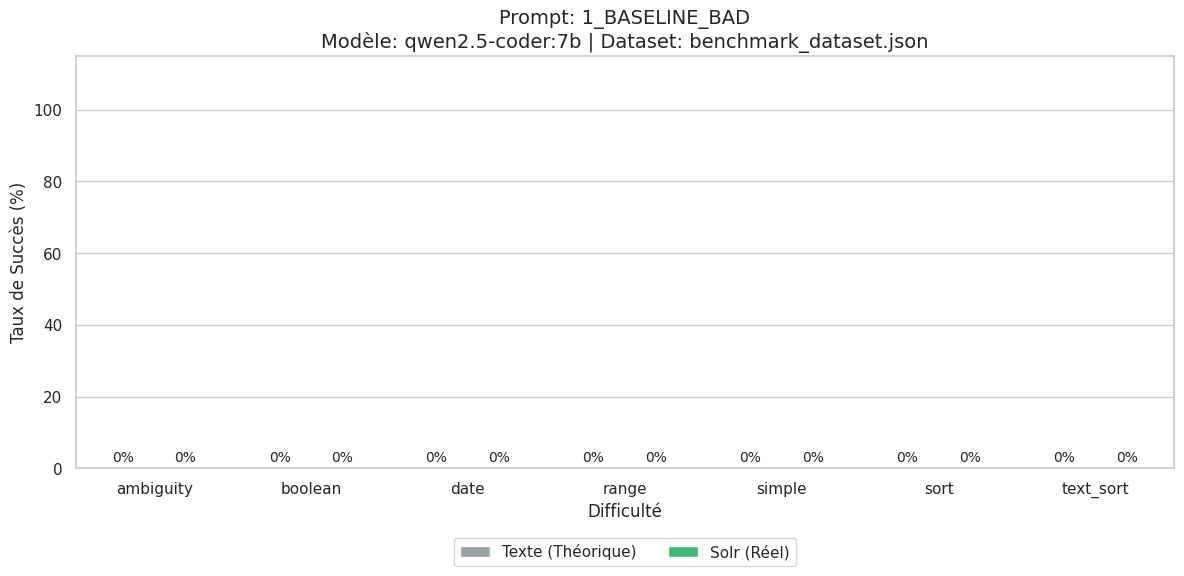

Graphique sauvegardé : graphs/qwen2.5-coder-7b/benchmark_dataset/2_SCHEMA_ONLY_2026-02-11_11-24-42.png


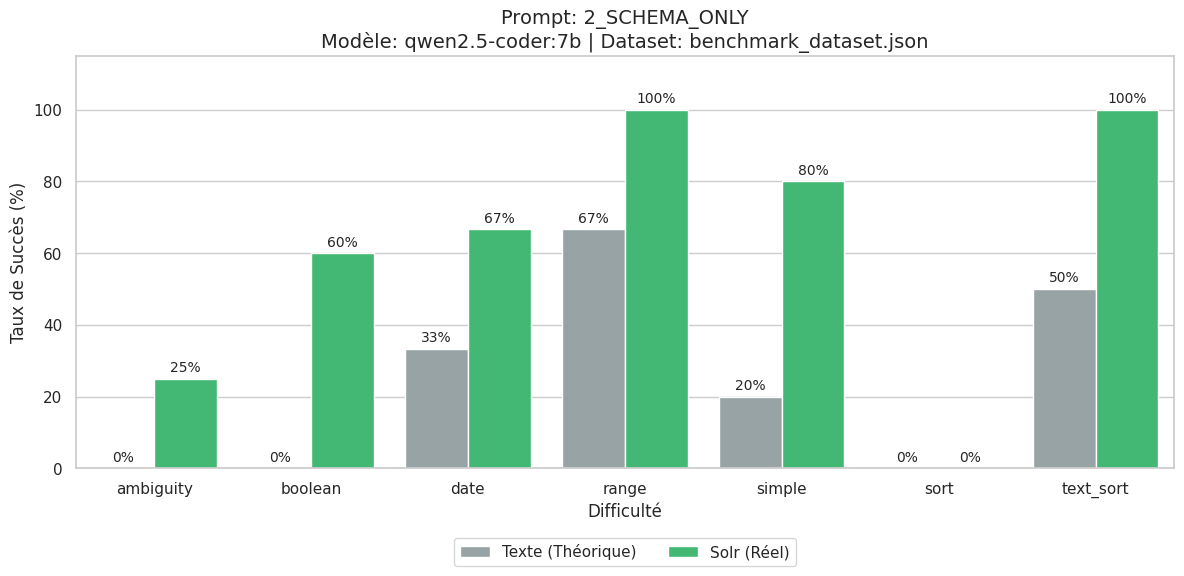

Graphique sauvegardé : graphs/qwen2.5-coder-7b/benchmark_dataset/3_SCHEMA_SYNTAX_2026-02-11_11-26-39.png


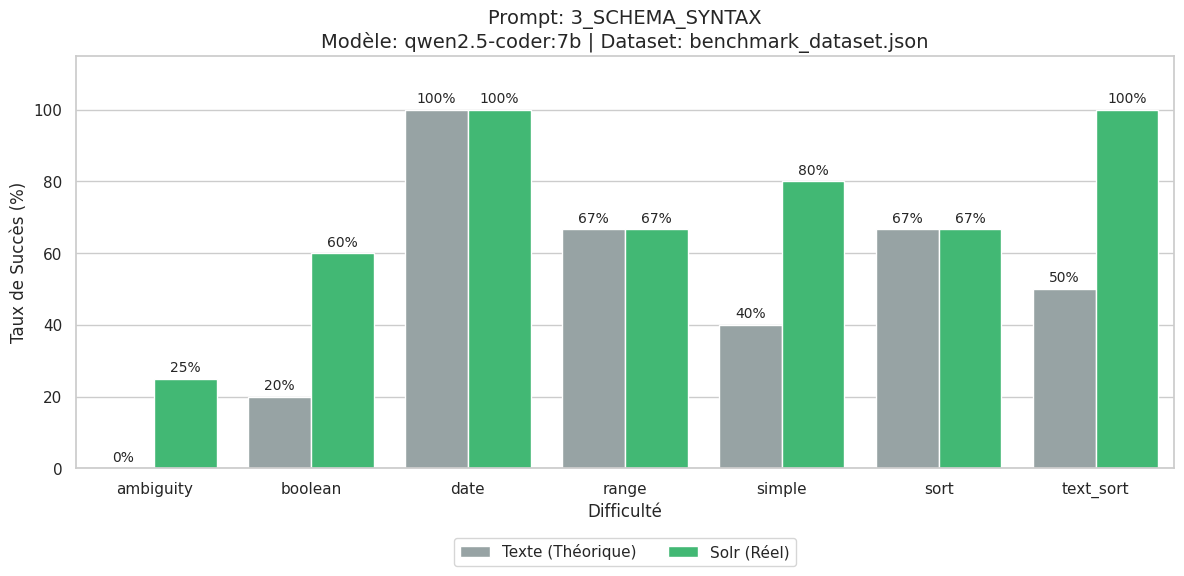

Graphique sauvegardé : graphs/qwen2.5-coder-7b/benchmark_dataset/4_SCHEMA_SYNTAX_FEWSHOT_2026-02-11_11-28-34.png


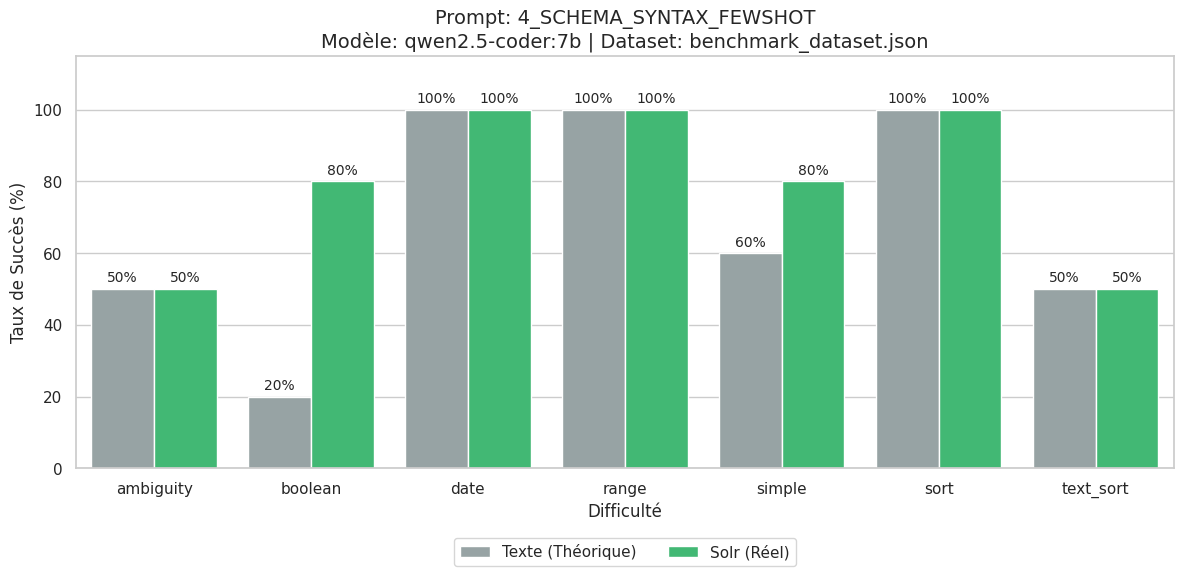


GÉNÉRATION DES GRAPHIQUES TERMINÉE


In [23]:

OUTPUT_ROOT = "graphs" # Dossier racine pour les images

if not exec_files:
    print("Aucun fichier de résultats validés trouvé.")
else:
    print(f"{len(exec_files)} fichiers à visualiser.")

    for filepath in exec_files:
        try:
            df = pd.read_json(filepath)

            model_name = df['model'].iloc[0] if 'model' in df.columns else model_name if model_name else "unknown_model"
            dataset_name = df['dataset'].iloc[0] if 'dataset' in df.columns else dataset_name if dataset_name else "unknown_dataset"
            prompt_name = df['system_prompt'].iloc[0] if 'system_prompt' in df.columns else "unknown_prompt"

            clean_model_name = model_name.replace(":", "-")
            clean_dataset_name = os.path.splitext(os.path.basename(dataset_name))[0]
            
            base_filename = os.path.basename(filepath)
            match_date = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})', base_filename)
            date_str = match_date.group(1) if match_date else "no_date"

            if 'execution_match' in df.columns:
                cols_to_keep = ['is_exact_match', 'execution_match']
                # Calcul des moyennes par difficulté
                df_grouped = df.groupby('difficulty')[cols_to_keep].mean() * 100
                df_grouped = df_grouped.reset_index()
                
                df_plot = df_grouped.melt(
                    id_vars='difficulty', 
                    var_name='Metric', 
                    value_name='Score'
                )
                
                df_plot['Metric'] = df_plot['Metric'].map({
                    'is_exact_match': 'Texte (Théorique)',
                    'execution_match': 'Solr (Réel)'
                })
                
                sns.set_theme(style="whitegrid")
                plt.figure(figsize=(12, 6))
                
                ax = sns.barplot(
                    x='difficulty', 
                    y='Score', 
                    hue='Metric', 
                    data=df_plot, 
                    palette=["#95a5a6", "#2ecc71"] # Gris (Texte) / Vert (Solr)
                )
                
                plt.title(f"Prompt: {prompt_name}\nModèle: {model_name} | Dataset: {dataset_name}", fontsize=14)
                plt.ylabel("Taux de Succès (%)")
                plt.xlabel("Difficulté")
                plt.ylim(0, 115)
                plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

                for container in ax.containers:
                    ax.bar_label(container, fmt='%.0f%%', padding=3, fontsize=10)
                
                plt.tight_layout()

                # Structure : graphs/modele/dataset/prompt_date.png
                save_dir = os.path.join(OUTPUT_ROOT, clean_model_name, clean_dataset_name)
                os.makedirs(save_dir, exist_ok=True)
                
                save_filename = f"{prompt_name}_{date_str}.png"
                full_save_path = os.path.join(save_dir, save_filename)
                
                plt.savefig(full_save_path)
                print(f"Graphique sauvegardé : {full_save_path}")

                if SHOW_PLOT:
                    plt.show()
                else:
                    plt.close()
            else:
                print(f"Ignoré (pas de données 'execution_match') : {filepath}")

        except Exception as e:
            print(f"Erreur sur {filepath}: {e}")

print("\nGÉNÉRATION DES GRAPHIQUES TERMINÉE")

## RAPPORT FINAL : Synthèse & Comparaison

C'est l'étape de **Visualisation Globale**. Ce script va compiler tous les résultats validés (`exec_files`) pour générer une vue d'ensemble de la performance de votre modèle.

**Ce que génère le script :**
Une image composite **3-en-1** sauvegardée dans `graphs/{NOM_MODELE}/` contenant :
1.  **Leaderboard :** Comparaison des scores (Théorique vs Réel) pour chaque Prompt.
2.  **Robustesse :** Le taux de requêtes qui font "planter" Solr (Erreur 400).
3.  **Heatmap :** Le détail des performances par difficulté (Dates, Tris, Booléens...).

> **Objectif :** Identifier en un coup d'œil quelle stratégie de Prompt est la plus efficace et la plus stable.

Génération du rapport comparatif pour 4 fichiers...

Image de synthèse sauvegardée : graphs/qwen2.5-coder-7b/benchmark_dataset_summary_2026-02-11_11-28-41.png


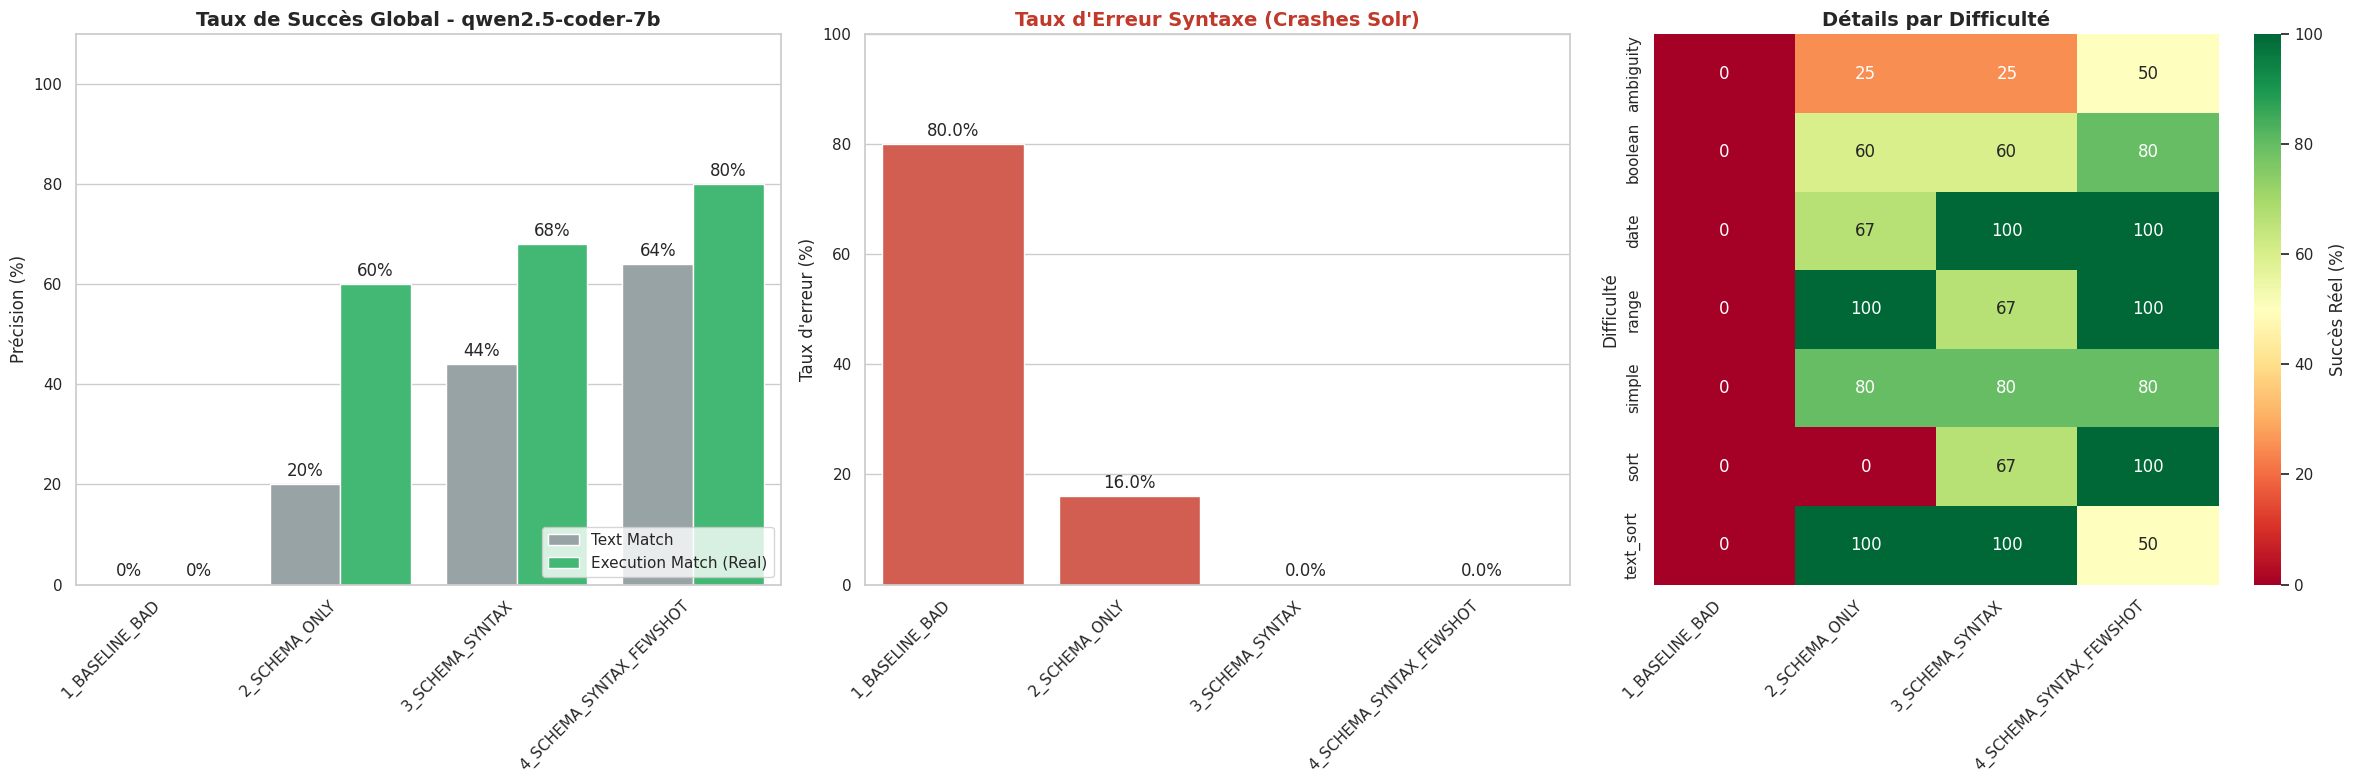

In [24]:
if not exec_files:
    print("Aucun fichier de résultats validés trouvé.")
else:
    print(f"Génération du rapport comparatif pour {len(exec_files)} fichiers...")

    summary_data = []
    detailed_data = []
    
    final_model_name = "unknown_model"
    final_dataset_name = "unknown_dataset"

    for filename in exec_files:
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            df_temp = pd.DataFrame(data)
            
            prompt_name = df_temp['system_prompt'].iloc[0] if 'system_prompt' in df_temp.columns else os.path.basename(filename)
            model_name = df_temp['model'].iloc[0] if 'model' in df_temp.columns else model_name if model_name else "unknown_model"
            dataset_name = df_temp['dataset'].iloc[0] if 'dataset' in df_temp.columns else dataset_name if dataset_name else "unknown_dataset"
            
            final_model_name = model_name.replace(":", "-")
            final_dataset_name = os.path.splitext(os.path.basename(dataset_name))[0]

            score_text = df_temp['is_exact_match'].mean() * 100
            score_exec = df_temp['execution_match'].mean() * 100
            
            if 'solr_error' in df_temp.columns:
                score_error = df_temp['solr_error'].mean() * 100
            else:
                score_error = 0.0

            summary_data.append({
                'Prompt Name': prompt_name,
                'Text Match': score_text,
                'Execution Match (Real)': score_exec,
                'Syntax Error Rate': score_error,
                'File Date': os.path.getctime(filename) # Pour trier
            })
            
            diff_scores = df_temp.groupby('difficulty')['execution_match'].mean() * 100
            for diff, score in diff_scores.items():
                detailed_data.append({
                    'Prompt Name': prompt_name,
                    'Difficulty': diff,
                    'Score': score
                })
                
        except Exception as e:
            print(f"Erreur lecture {filename}: {e}")

    if summary_data:
        df_summary = pd.DataFrame(summary_data).sort_values('Execution Match (Real)')
        
        sorted_prompts = df_summary['Prompt Name'].tolist()
        
        sns.set_theme(style="whitegrid")
        fig = plt.figure(figsize=(24, 8))
        
        ax1 = plt.subplot(1, 3, 1)
        df_melted = df_summary.melt(id_vars='Prompt Name', value_vars=['Text Match', 'Execution Match (Real)'], var_name='Metric', value_name='Score')
        
        sns.barplot(x='Prompt Name', y='Score', hue='Metric', data=df_melted, palette=["#95a5a6", "#2ecc71"], ax=ax1)
        ax1.set_title(f"Taux de Succès Global - {final_model_name}", fontsize=14, fontweight='bold')
        ax1.set_ylim(0, 110)
        ax1.set_ylabel("Précision (%)")
        ax1.set_xlabel("")
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        ax1.legend(loc='lower right')
        for c in ax1.containers: ax1.bar_label(c, fmt='%.0f%%', padding=3)

        ax2 = plt.subplot(1, 3, 2)
        sns.barplot(x='Prompt Name', y='Syntax Error Rate', data=df_summary, color="#e74c3c", ax=ax2)
        ax2.set_title("Taux d'Erreur Syntaxe (Crashes Solr)", fontsize=14, fontweight='bold', color="#c0392b")
        ax2.set_ylim(0, 100)
        ax2.set_ylabel("Taux d'erreur (%)")
        ax2.set_xlabel("")
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        for c in ax2.containers: ax2.bar_label(c, fmt='%.1f%%', padding=3)

        ax3 = plt.subplot(1, 3, 3)
        df_detail = pd.DataFrame(detailed_data)
        heatmap_data = df_detail.pivot(index='Difficulty', columns='Prompt Name', values='Score')
        heatmap_data = heatmap_data[sorted_prompts]
        
        sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="RdYlGn", vmin=0, vmax=100, cbar_kws={'label': 'Succès Réel (%)'}, ax=ax3)
        ax3.set_title("Détails par Difficulté", fontsize=14, fontweight='bold')
        ax3.set_xlabel("")
        ax3.set_ylabel("Difficulté")
        plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

        plt.tight_layout()

        # Dossier : graphs/{model_name}/
        save_dir = os.path.join("graphs", final_model_name)
        os.makedirs(save_dir, exist_ok=True)
        
        # Nom : {dataset}_summary_{date}.png
        date_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        save_name = f"{final_dataset_name}_summary_{date_str}.png"
        full_path = os.path.join(save_dir, save_name)
        
        plt.savefig(full_path)
        print(f"\nImage de synthèse sauvegardée : {full_path}")
        
        # Affichage
        plt.show()

    else:
        print("Aucune donnée valide pour générer le graphique.")